In [53]:
# imports
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import mat73
from IPython.display import display, Markdown

import pyaldata as pyal
import pylab
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from tools.curbd import curbd
import pylab
import importlib

from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd.RNN_functions import *

np.random.seed(44)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [30]:
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
mat_file = "M044_2024_12_04_09_30_pyaldata.mat"
fname = os.path.join(data_dir, mat_file)

df = pyal.mat2dataframe(fname, shift_idx_fields=True)
mouse = mat_file.split('_')[0]

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


### Preprocess

In [31]:
df_ = preprocess(df, only_trials=True)
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off

# Separate columns of 'all_spikes' to M1 and Dls (dorsolateral striatum)
brain_areas = ["Dls_rates", "M1_rates"]
df_["M1_rates"] = [df_["all_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_rates"][i][:,0:300] for i in range(len(df_))]

/home/zms24/.conda/envs/zofia_earthquake_env/earthquake-analysis/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


### Variables

In [32]:
# perturbation time
perturbation_time = df_.idx_sol_on[0]
perturbation_time_seconds = perturbation_time * df_.bin_size[0]

# solenoid angles
sol_angles: list = df_.values_Sol_direction.unique()
sol_angles.sort()

# number of trials
num_trials = len(df_)
print(f"Number of trials: {num_trials}")

Number of trials: 493


### Concatinate all trials in time

In [33]:
concat_trials = pyal.concat_trials(df_, signal = "all_rates")

#### Plot concatinted activity

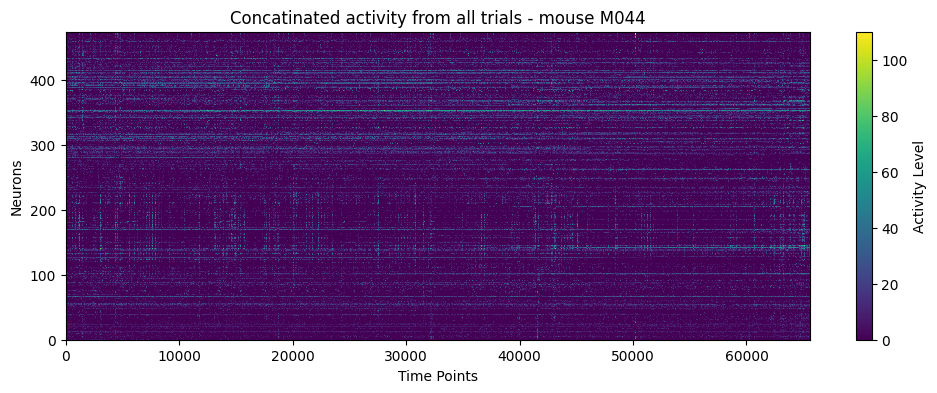

In [34]:
plot_neuron_activity(concat_trials, "Concatinated activity from all trials", mouse)

### Set up inputs for RNN training

In [35]:
reset_points, trial_len = get_reset_points(df_, concat_trials, brain_areas)
activity = np.transpose(concat_trials)
regions = get_regions(df_, brain_areas)

print(f"Building {len(regions)} region RNN network")
print(f"Regions: {[region[0] for region in regions]}\n")

Trial length: 133
Building 2 region RNN network
Regions: ['Dls', 'M1']



### RNN training

trial=0 pVar=0.437611 chi2=212.655581
trial=1 pVar=0.440348 chi2=212.744031
trial=2 pVar=0.431806 chi2=215.925960
trial=3 pVar=0.430983 chi2=216.170441
trial=4 pVar=0.431482 chi2=215.916040
trial=5 pVar=0.432340 chi2=215.537652
trial=6 pVar=0.436504 chi2=213.912536
trial=7 pVar=0.438408 chi2=213.157368
trial=8 pVar=0.441476 chi2=211.965955
trial=9 pVar=0.442812 chi2=211.438390
trial=10 pVar=0.443863 chi2=211.023098
trial=11 pVar=0.444506 chi2=210.765608
trial=12 pVar=0.444806 chi2=210.640248
trial=13 pVar=0.444981 chi2=210.563747
trial=14 pVar=0.445129 chi2=210.498702
trial=15 pVar=0.445304 chi2=210.424285
trial=16 pVar=0.445524 chi2=210.333491
trial=17 pVar=0.445780 chi2=210.229665
trial=18 pVar=0.446058 chi2=210.118267
trial=19 pVar=0.446340 chi2=210.005463
trial=20 pVar=0.446608 chi2=209.898571
trial=21 pVar=0.446844 chi2=209.804302
trial=22 pVar=0.447036 chi2=209.726906
trial=23 pVar=0.447182 chi2=209.667474
trial=24 pVar=0.447286 chi2=209.624309
trial=25 pVar=0.447356 chi2=209.593

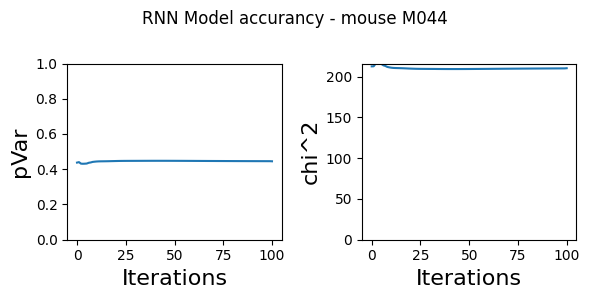

In [36]:
# RNN TRAINING
rnn_model, rnn_accurancy_figure = RNN(activity, reset_points, regions, df_, mouse, 
                                                        dtFactor = 1, ampInWN= 0.01, tauRNN = 0.2, nRunTrain=100)

#### Plot activity generated by RNN

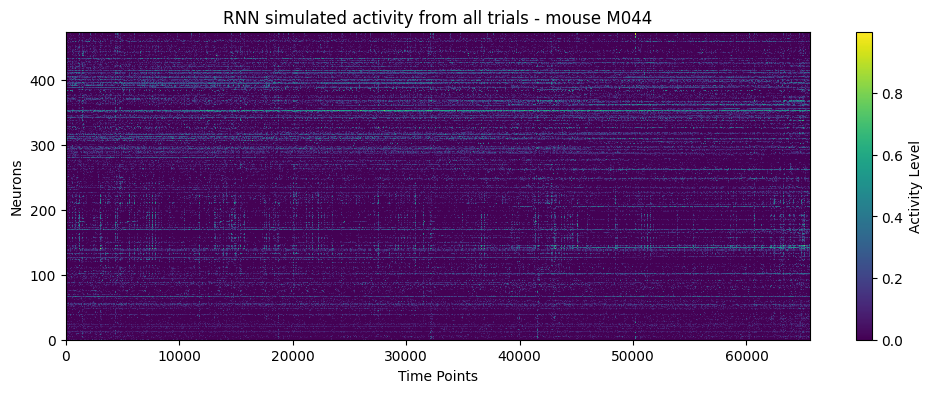

In [37]:
plot_neuron_activity(rnn_model['Adata'].T, "RNN simulated activity from all trials", mouse)

### RNN assesment with PCA and CCA

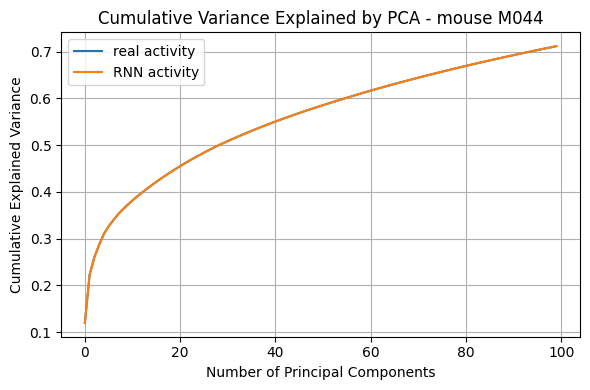

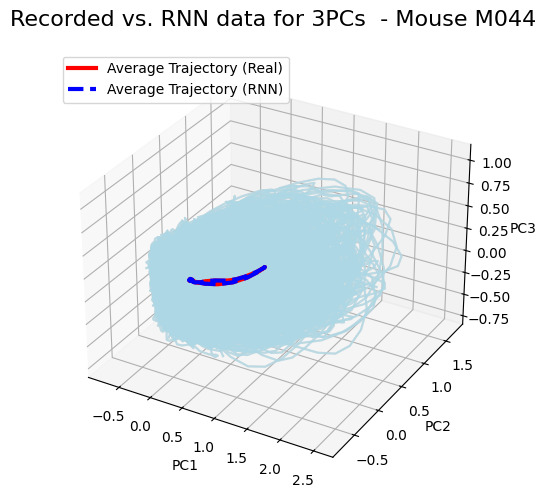

CCA score of real data and RNN data aligment: 0.9999994530118435
CCA score for control on real data: 0.9999999999999994
CCA score for control on rnn data: 0.9999999999999994


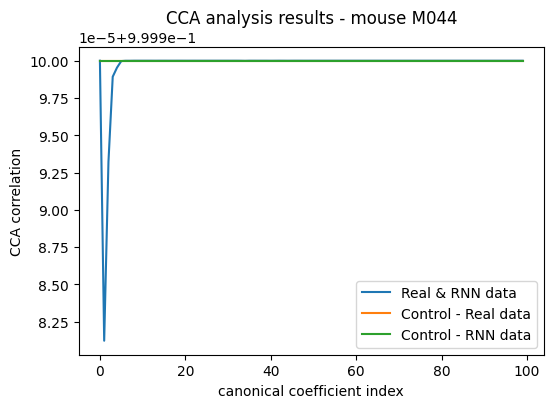

In [38]:
scores, variance_figure, PCA_figure, CCA_figure = PCA_and_CCA(concat_trials, rnn_model, 
                                                                  num_components = 100, trial_num = num_trials, mouse_num = mouse, 
                                                                  printing=True)

### CURBD

In [39]:
curbd_arr, curbd_labels = curbd.computeCURBD(rnn_model)
n_regions = curbd_arr.shape[0]

### Plotting currents

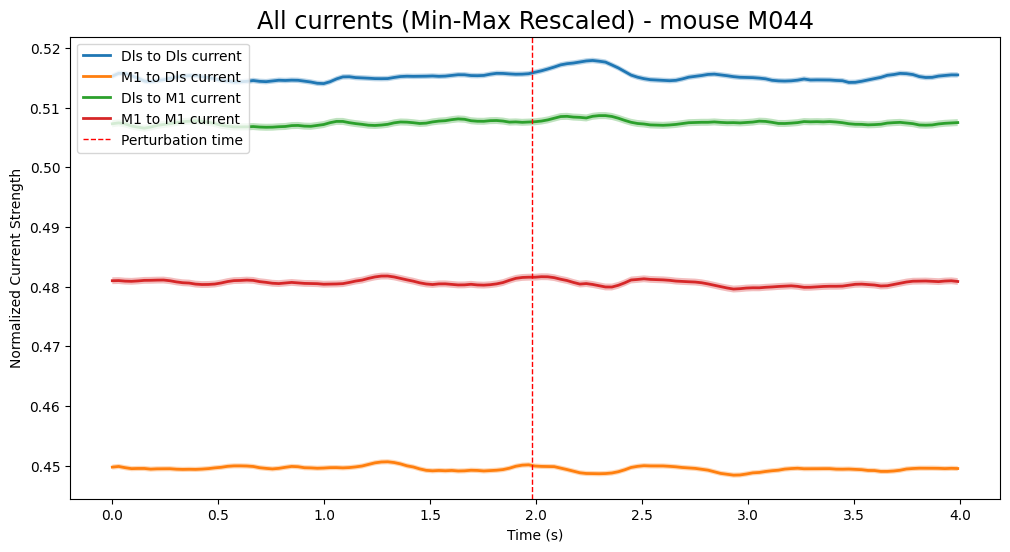

In [ ]:
all_currents, all_currents_labels = format_for_plotting(curbd_arr, curbd_labels, n_regions, trial_len, 
                                                                          num_trials)
all_currents_fig = plot_all_currents(all_currents, all_currents_labels, perturbation_time_seconds, df_.bin_size[0], mouse, normalize='min-max')

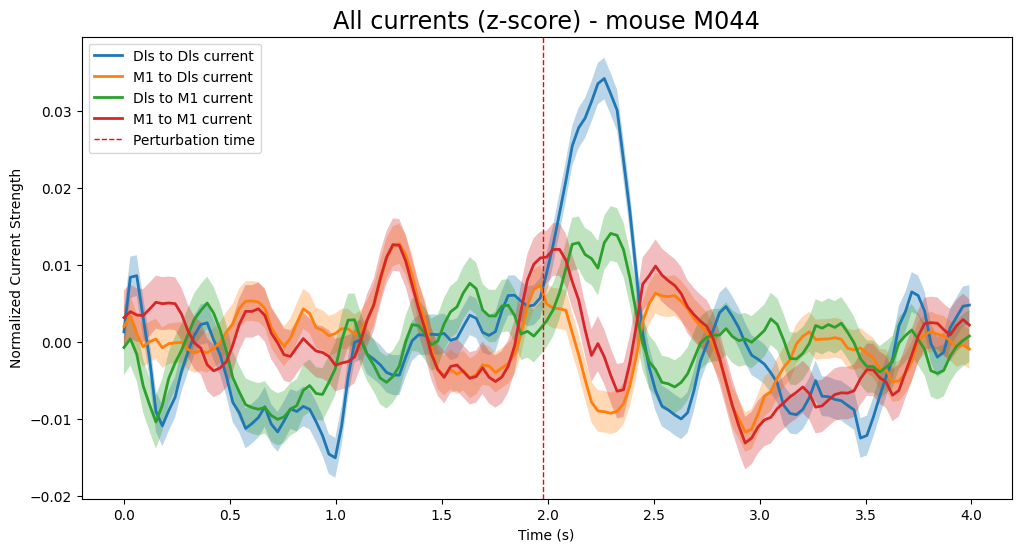

In [60]:
all_currents_z_score_fig = plot_all_currents(all_currents, all_currents_labels, perturbation_time_seconds, df_.bin_size[0], mouse, normalize='z-score')